# [LAB 12] 6.로지스틱회귀 - pima_indians_diabetes

### #01.준비작업
#### 1. 라이브러리 참조

In [1]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

# 로지스틱을 위한 참조
import statsmodels.api as sm

# 로지스틱 결과 판별을 위한 참조
# -> 머신러닝 라이브러리를 미리 사용함
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### 2.그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### 3. 데이터 가져오기


In [3]:
origin = load_data('pima_indians_diabetes')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/kaggle/pima_indians_diabetes.xlsx
[desc] 이 데이터 세트는 원래 미국 국립 당뇨병·소화기·신장질환 연구소(National Institute of Diabetes and Digestive and Kidney Diseases)에서 제공한 것입니다. 이 데이터 세트의 목적은 데이터 세트에 포함된 특정 진단 측정값을 기반으로 환자의 당뇨병 여부를 진단적으로 예측하는 것입니다. 더 큰 데이터베이스에서 이러한 사례를 선택하는 데에는 몇 가지 제약 조건이 적용되었습니다. 특히, 여기에 포함된 모든 환자는 21세 이상의 피마 인디언 혈통을 가진 여성입니다. (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

field                     type    description
------------------------  ------  --------------------------------
Pregnancies               연속형  임신횟수
Glucose                   연속형  포도당 부하 검사 수치
BloodPressure             연속형  혈압
SkinThickness             연속형  팔 삼두근 뒤쪽의 피하지방 측정값
Insulin                   연속형  혈청 인슐린
BMI                       연속형  체질량 지수
DiabetesPedigreeFunction  연속형  당뇨 내력 가중치 값
Age                       연속형  나이
Outcome                   명목형  당뇨여부(0 또는 1)


==== 데이터 크기 확인 ====
데이터셋 크기: (768, 9)
열 개수: 9
행 개수: 768

==== 타입확인 ====
<class 'pandas.c

### #02.기존분석
- 전처리 없이 분류 모형 구축

#### 1. 모델 구축

In [4]:
yname = 'Outcome'   #종속 변수 이름


x=origin.drop(yname,axis=1)   #독립변수만 추출 (dataframe 형태)

y=origin[yname]   #종속변수만 추출 (series 형태)


x_input = sm.add_constant(x)   #독립변수에 상수항 추가


fit = sm.Logit(y,x_input).fit()
tbl1 = fit.summary()
print(tbl1)




Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                  0.2718
Time:                        10:16:34   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -8.4047      0.717    -11.728      0.000      -9.809

#### 2.결과보고 함수 정의

In [5]:
def logit_report(fit, data, threshold=0.5):
    """
    Logit summary(tbl)와 데이터프레임(data)을 받아
    회귀계수 표(rdf),
    모델 적합도 요약(result_report),
    모델 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.
    """

    # --------------------------
    # 성능평가지표
    # --------------------------
    yname = fit.model.endog_names
    y_true = data[yname]
    y_pred = fit.predict(fit.model.exog)
    y_pred_fix = (y_pred >= threshold).astype(int)

    # 혼동행렬
    cm = confusion_matrix(y_true, y_pred_fix)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_true, y_pred_fix)          # 정확도
    pre = precision_score(y_true, y_pred_fix)         # 정밀도
    tpr = recall_score(y_true, y_pred_fix)            # 재현율
    fpr = fp / (fp + tn)                               # 위양성율
    tnr = 1 - fpr                                     # 특이성
    f1  = f1_score(y_true, y_pred_fix)                # F1-score
    ras = roc_auc_score(y_true, y_pred)               # AUC score

    cdf = DataFrame({
        '설명력(P-Rsqe)': [fit.prsquared],
        '정확도(Accuracy)': [acc],
        '정밀도(Precision)': [pre],
        '재현율(Recall,TPR)': [tpr],
        '위양성율(Fallout,FPR)': [fpr],
        '특이성(Specificity,TNR)': [tnr],
        'RAS(auc score)': [ras],
        'F1': [f1]
    })

    # --------------------------
    # 회귀계수 표 구성 (OR 중심)
    # --------------------------
    tbl = fit.summary()

    # 종속변수명
    yname = fit.model.endog_names

    # 독립변수 이름 (상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 데이터
    x = data[xnames]

    # VIF 계산
    vif_dict = {
        col: variance_inflation_factor(x.values, i)
        for i, col in enumerate(x.columns)
    }

    variables = []

    for v in tbl.tables[1].data:
        name = v[0].strip()
        if name not in xnames:
            continue

        beta = float(v[1])
        se   = float(v[2])
        z    = float(v[3])
        p    = float(v[4])

        or_val  = np.exp(beta)
        ci_low  = np.exp(beta - 1.96 * se)
        ci_high = np.exp(beta + 1.96 * se)

        stars = (
            "***" if p < 0.001 else
            "**"  if p < 0.01 else
            "*"   if p < 0.05 else
            ""
        )

        variables.append({
            "종속변수": yname,
            "독립변수": name,
            "B(β)": beta,
            "표준오차": se,
            "z": f"{z:.3f}{stars}",
            "p-value": p,
            "OR": or_val,
            "CI_lower": ci_low,
            "CI_upper": ci_high,
            "VIF": vif_dict.get(name, np.nan)
        })

    rdf = DataFrame(variables)

    # --------------------------
    # 모델 적합도 요약
    # --------------------------
    result_report = (
        f"Pseudo R²(McFadden) = {fit.prsquared:.3f}, "
        f"LLR χ²({int(fit.df_model)}) = {fit.llr:.3f}, "
        f"p-value = {fit.llr_pvalue:.4f}, "
        f"Accuracy = {acc:.3f}, "
        f"AUC = {ras:.3f}"
    )

    # --------------------------
    # 모델 보고 문장
    # --------------------------
    tpl = (
        "%s에 대하여 %s로 예측하는 로지스틱 회귀분석을 실시한 결과, "
        "모형은 통계적으로 %s(χ²(%s) = %.3f, p %s 0.05)하였다."
    )

    model_report = tpl % (
        yname,
        ", ".join(xnames),
        "유의하였다" if fit.llr_pvalue <= 0.05 else "유의하지 않았다",
        int(fit.df_model),
        fit.llr,
        "<" if fit.llr_pvalue <= 0.05 else ">"
    )

    # --------------------------
    # 변수별 보고 문장
    # --------------------------
    variable_reports = []

    s = (
        "%s의 오즈비는 %.3f(p %s 0.05)로, "
        "%s 발생 odds에 %s 영향을 미치는 것으로 나타났다."
    )

    for _, row in rdf.iterrows():
        variable_reports.append(
            s % (
                row["독립변수"],
                row["OR"],
                "<" if row["p-value"] < 0.05 else ">",
                row["종속변수"],
                "유의미한" if row["p-value"] < 0.05 else "유의하지 않은"
            )
        )

    return cdf, rdf, result_report, model_report, variable_reports


#### 3.분석결과 보고

In [6]:
cdf , rdf , r,m,v=logit_report(fit,origin)

display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,설명력(P-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall,TPR)","위양성율(Fallout,FPR)","특이성(Specificity,TNR)",RAS(auc score),F1
0,0.27181,0.782552,0.739336,0.58209,0.11,0.89,0.839425,0.651357


,종속변수,독립변수,B(β),표준오차,z,p-value,OR,CI_lower,CI_upper,VIF
0,Outcome,Pregnancies,0.1232,0.032,3.840***,0.000,1.131111,1.062346,1.204326,3.275748
1,Outcome,Glucose,0.0352,0.004,9.481***,0.000,1.035827,1.027738,1.043980,16.725078
2,Outcome,BloodPressure,-0.0133,0.005,-2.540*,0.011,0.986788,0.977165,0.996506,14.619512
3,Outcome,SkinThickness,0.0006,0.007,0.090,0.929,1.000600,0.986966,1.014423,4.008696
4,Outcome,Insulin,-0.0012,0.001,-1.322,0.186,0.998801,0.996845,1.000760,2.063689
5,Outcome,BMI,0.0897,0.015,5.945***,0.000,1.093846,1.062155,1.126483,18.408884
6,Outcome,DiabetesPedigreeFunction,0.9452,0.299,3.160**,0.002,2.573328,1.432126,4.623907,3.195626
7,Outcome,Age,0.0149,0.009,1.593,0.111,1.015012,0.997264,1.033075,13.492985


'Pseudo R²(McFadden) = 0.272, LLR χ²(8) = 270.039, p-value = 0.0000, Accuracy = 0.783, AUC = 0.839'

'Outcome에 대하여 Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age로 예측하는 로지스틱 회귀분석을 실시한 결과, 모형은 통계적으로 유의하였다(χ²(8) = 270.039, p < 0.05)하였다.'

['Pregnancies의 오즈비는 1.131(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'Glucose의 오즈비는 1.036(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'BloodPressure의 오즈비는 0.987(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'SkinThickness의 오즈비는 1.001(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'Insulin의 오즈비는 0.999(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'BMI의 오즈비는 1.094(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'DiabetesPedigreeFunction의 오즈비는 2.573(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'Age의 오즈비는 1.015(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.']

- 로지스틱에서 vif 는 참고용일 뿐, vif 가 10을 넘는다고 해서 제거할 필요는 없다
- vif 자체가 선형성일 떄 사용되는 값이기 때문이다
- 즉, 로지스틱에서 vif 가 10 을 넘는다는 것은 이 변수가 다른 독립변수들과 강하게 선형적으로 얽혀있따는 뜻이지 이 변수가 틀렸따, 쓸수없다는 의미는 아니다

#### 4.AUC 시각화 


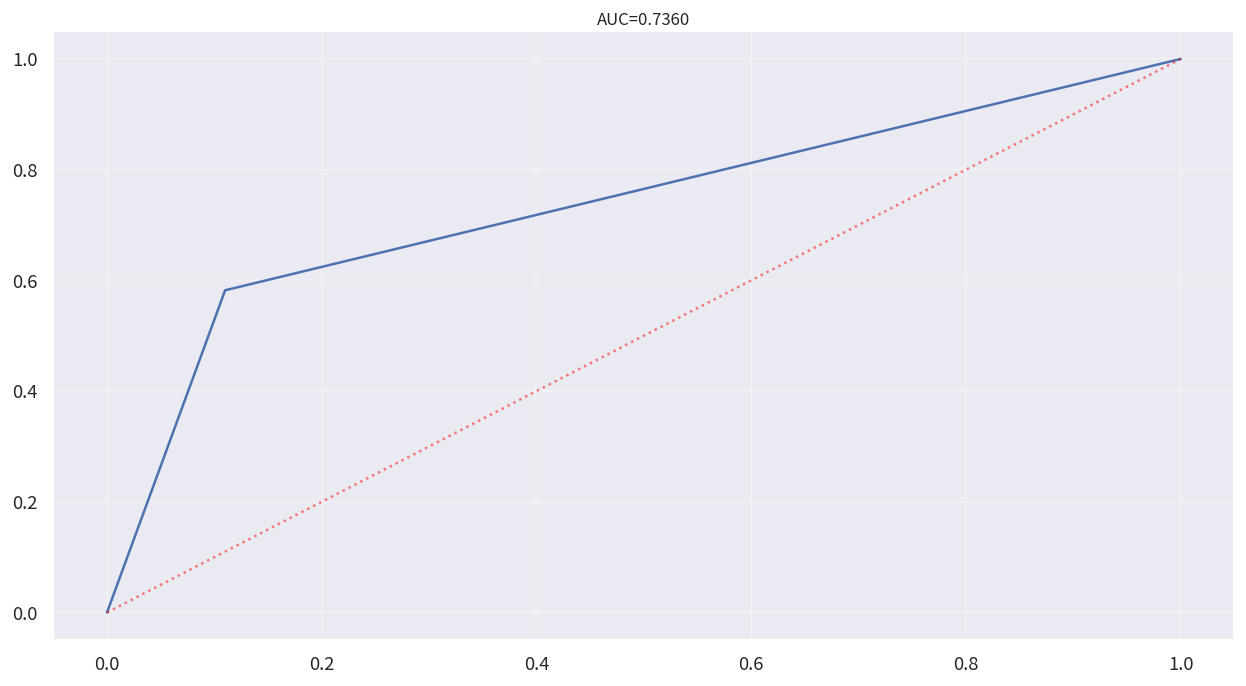

In [ ]:
y_true = origin[yname]
y_prob = fit.predict(fit.model.exog)
y_pred = (y_prob >= 0.5).astype(int)


ras = roc_auc_score(y_true , y_pred)

roc_fpr , roc_tpr , thresholds = roc_curve(y_true,y_pred)

# 1) 그래프 초기화
width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LinePlot 그리기
sb.lineplot(x=roc_fpr, y=roc_tpr)
sb.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle=':', alpha=0.5)

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)
ax.set_title(f'AUC={ras:.4f}', fontsize=10, pad=4)

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

| AUC 값 | 일반적 해석 |
|------|------------|
| 0.5 | 무작위 수준 |
| 0.6 ~ 0.7 | 낮음 |
| 0.7 ~ 0.8 | 양호 (acceptable / fair) |
| 0.8 ~ 0.9 | 우수 |
| 0.9 이상 | 매우 우수 |


> 로지스틱 회귀모형의 AUC 는 0.736 으로 인디안의 당뇨병 여부를 구분하는데 있어 수용 가능한 수준의 판별 성능을 보이는 것으로 해석할 수 있다

### #02. 독립변수 로그 변환
#### 1. 로그 변환 후 다시 분석

In [9]:
#1. 복사
df = origin.copy()

#2.종속/독립변수
yname = "Outcome"
y=df[yname]
x=df.drop(columns=[yname])



#3.로그변환 대상 변수 (연속형만 명시)
log_vars = x.columns


#4. 로그변환 (0값 대응)
for v in log_vars:
  df[f"log_{v}"] = np.log1p(df[v])


#5. 원변수 제거
df.drop(columns = log_vars,inplace=True)



#6.로지스틱 회귀
x_log = df.drop(columns=[yname])
x_input=sm.add_constant(x_log)


fit = sm.Logit(y,x_input).fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.516943
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                  0.2008
Time:                        10:37:02   Log-Likelihood:                -397.01
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 8.305e-39
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -25.6571      2.490    -10.303      0.000

In [10]:
cdf , rdf , r,m,v = logit_report(fit,df)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,설명력(P-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall,TPR)","위양성율(Fallout,FPR)","특이성(Specificity,TNR)",RAS(auc score),F1
0,0.200768,0.769531,0.719807,0.55597,0.116,0.884,0.836187,0.627368


,종속변수,독립변수,B(β),표준오차,z,p-value,OR,CI_lower,CI_upper,VIF
0,Outcome,log_Pregnancies,0.3125,0.136,2.305*,0.021,1.366838,1.047012,1.784360,5.186143
1,Outcome,log_Glucose,2.9775,0.404,7.366***,0.000,19.638659,8.896518,43.351443,88.500549
2,Outcome,log_BloodPressure,-0.2716,0.106,-2.562*,0.010,0.762159,0.619180,0.938155,25.483998
3,Outcome,log_SkinThickness,0.0359,0.077,0.469,0.639,1.036552,0.891348,1.205410,6.105680
4,Outcome,log_Insulin,-0.0416,0.047,-0.879,0.379,0.959253,0.874835,1.051818,3.618666
5,Outcome,log_BMI,1.9870,0.467,4.253***,0.000,7.293620,2.920281,18.216358,59.762583
6,Outcome,log_DiabetesPedigreeFunction,1.6688,0.452,3.689***,0.000,5.305797,2.187764,12.867696,4.668408
7,Outcome,log_Age,1.1022,0.342,3.220**,0.001,3.010782,1.540150,5.885667,118.849755


'Pseudo R²(McFadden) = 0.201, LLR χ²(8) = 199.460, p-value = 0.0000, Accuracy = 0.770, AUC = 0.836'

'Outcome에 대하여 log_Pregnancies, log_Glucose, log_BloodPressure, log_SkinThickness, log_Insulin, log_BMI, log_DiabetesPedigreeFunction, log_Age로 예측하는 로지스틱 회귀분석을 실시한 결과, 모형은 통계적으로 유의하였다(χ²(8) = 199.460, p < 0.05)하였다.'

['log_Pregnancies의 오즈비는 1.367(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_Glucose의 오즈비는 19.639(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_BloodPressure의 오즈비는 0.762(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_SkinThickness의 오즈비는 1.037(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'log_Insulin의 오즈비는 0.959(p > 0.05)로, Outcome 발생 odds에 유의하지 않은 영향을 미치는 것으로 나타났다.',
 'log_BMI의 오즈비는 7.294(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_DiabetesPedigreeFunction의 오즈비는 5.306(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.',
 'log_Age의 오즈비는 3.011(p < 0.05)로, Outcome 발생 odds에 유의미한 영향을 미치는 것으로 나타났다.']

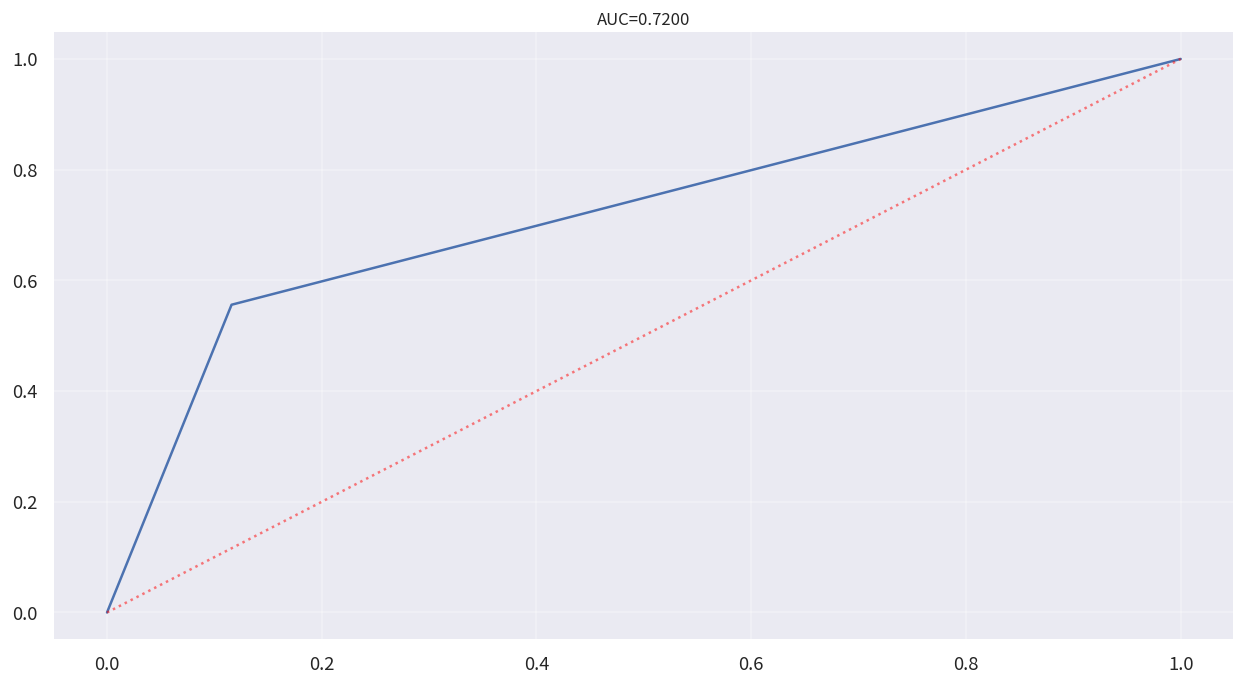

In [11]:
y_true = origin[yname]
y_prob = fit.predict(fit.model.exog)
y_pred = (y_prob >= 0.5).astype(int)


ras = roc_auc_score(y_true , y_pred)

roc_fpr , roc_tpr , thresholds = roc_curve(y_true,y_pred)

# 1) 그래프 초기화
width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LinePlot 그리기
sb.lineplot(x=roc_fpr, y=roc_tpr)
sb.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle=':', alpha=0.5)

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)
ax.set_title(f'AUC={ras:.4f}', fontsize=10, pad=4)

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

> 이 데이터와 이 연구 질문에서는 로그 변환이 적합하지 않았다 (로그변환 후 설득력이 더 떨어짐)